## Prerequisites
필요 라이브러리: numpy, matplotlib

코드를 실행하기 전 아래 import 및 class definition 셀을 실행해 주세요

In [1]:
# Import Libraries(numpy, matplotlib) and Define basic classes(Set, Cache)
# Math
import numpy as np
# Plot
from matplotlib import pyplot as plt

# Set
class Set:
    def __init__(self, way, index):
        self.entries = [[False, 0] for i in range(way)]
        self.ways = way
        self.index = index

    def access(self, tag) -> int:
        hit = False
        hit_index = -1
        for idx, entry in enumerate(self.entries):
            if entry[0] and (entry[1] == tag):
                hit = True
                hit_index = idx
                break
        #
        if hit:
            # update LRU
            for idx in range(hit_index, 0, -1):
                self.entries[idx][0] = self.entries[idx-1][0]
                self.entries[idx][1] = self.entries[idx-1][1]
            self.entries[0][0] = True
            self.entries[0][1] = tag
            return 0
        else:
            # evict LRU
            if self.entries[-1][0]:
                # print(f"Set #{self.index:04x}: Tag ${self.entries[-1][1]:08x} is evicted.")
                pass
            for idx in range(len(self.entries)-1, 0, -1):
                self.entries[idx][0] = self.entries[idx-1][0]
                self.entries[idx][1] = self.entries[idx-1][1]
            self.entries[0][0] = True
            self.entries[0][1] = tag
            return 1
            
    def flush(self):
        for entry in self.entries:
            entry[0] = False
            entry[1] = 0

# Cache
class Cache:
    def __init__(self, size=512, block=16, way=4):
        assert (size > 0) and (block > 0) and (way > 0), "Arguments should be positive integers"
        assert (size % (block * way)) == 0, "Size must be exactly divided by each set!"
        set_count = size // (block * way)
        tag_span = set_count * block
        self.size = size; self.block = block; self.tag_span = tag_span
        self.cache = [Set(way, i) for i in range(set_count)]
        self.miss_count = 0
        self.access_count = 0

    def access(self, addr):
        tag = addr // self.tag_span
        set_index = (addr % self.tag_span) // self.block
        self.miss_count += self.cache[set_index].access(tag)
        self.access_count += 1

    def flush(self):
        for set in self.cache:
            set.flush()
        self.miss_count = 0
        self.access_count = 0

## Code

(1) Number of sets:             8
(2) Number of bits in a tag:    25
(3)
Total number of L/S instr. executed:    32
Total number of cache misses:           17
<!-- contents of the cache:
Set #0: B[0][0] ~ B[0][3]
Set #1: B[1][0] ~ B[1][3]
Set #2: B[2][0] ~ B[2][3]
Set #3: B[3][0] ~ B[3][3]
Set #4: 
Set #5: 
Set #6: 
Set #7: 
-->
(4)
[Total number of cache misses]
- 2-way set associative:    1280
- fully associative:        1280
(5)


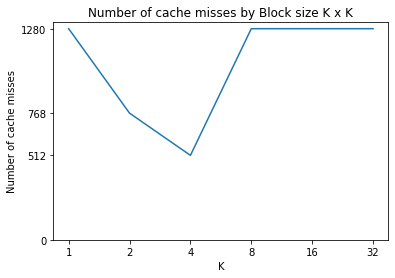

In [2]:
dmap = Cache(128, 16, 1)
way2 = Cache(128, 16, 2)
full = Cache(128, 16, 8)

# 4-(1),(2)
print(f"(1) Number of sets:             {len(dmap.cache)}")
print(f"(2) Number of bits in a tag:    " +
f"{32 - int(np.log2(len(dmap.cache))) - int(np.log2(dmap.block))}")

# 4-(3)
for n in [4]:
    A = 0x80010000
    B = 0x80018000

    dmap.flush()
    for i in range(n):
        for j in range(n):
            dmap.access(A + 16 * i + 4 * j); dmap.access(B + 16 * j + 4 * i)

    print("(3)")
    print(f"Total number of L/S instr. executed:    {dmap.access_count}")
    print(f"Total number of cache misses:           {dmap.miss_count}")
    print("<!-- contents of the cache:")
    for set in dmap.cache:
        head = (set.entries[0][1] * 128)
        content =   f"A[{set.index}][0] ~ A[{set.index}][3]" if head == A else \
                    f"B[{set.index}][0] ~ B[{set.index}][3]" if head == B else \
                    f"0x{(head + set.index * 16):08x}" if set.entries[0][0] else \
                    ""
        print(f"Set #{set.index}: {content}")
    print("-->")

# 4-(4)
for n in [32]:
    A = 0x80010000
    B = 0x80018000

    way2.flush(); full.flush()
    for i in range(n):
        for j in range(n):
            way2.access(A + 128 * i + 4 * j); way2.access(B + 128 * j + 4 * i)
            full.access(A + 128 * i + 4 * j); full.access(B + 128 * j + 4 * i)

    print("(4)\n[Total number of cache misses]")
    print(f"- 2-way set associative:    {way2.miss_count}")
    print(f"- fully associative:        {full.miss_count}")

# 4-(5)
N = 32
K = [1, 2, 4, 8, 16, 32]
miss_count = []
for k in K:
    A = 0x80010000
    B = 0x80018000

    full.flush()
    for i in range(0, N, k):
        for j in range(0, N, k):
            for ii in range(i, i+k):
                for jj in range(j, j+k):
                    full.access(A + 128 * ii + 4 * jj)
                    full.access(B + 128 * jj + 4 * ii)
    
    miss_count.append(full.miss_count)

print("(5)")
plt.plot(range(6), miss_count)

plt.title("Number of cache misses by Block size K x K")
plt.xlabel("K")
plt.xticks(range(6), K)
plt.ylabel("Number of cache misses")
plt.yticks(np.unique(miss_count + [0]))
plt.show()